In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

In [2]:
EMPRESA = 'ELET3.SA'

## Funções

In [3]:
def dias_uteis_entre_datas(start_date,end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')

    date_list = date_range.strftime('%Y-%m-%d').tolist()

    return date_list


In [4]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].shift(-1)
    return data_hist

In [5]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='5y')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [6]:
def adiciona_nova_linha(df, novo_fechamento, data):
    new_row = {
            'Close': novo_fechamento,
            'prev-day-1': df.iloc[-1]['Close'] if len(df) >= 1 else None,
            'prev-day-2': df.iloc[-2]['Close'] if len(df) >= 2 else None,
            'prev-day-3': df.iloc[-3]['Close'] if len(df) >= 3 else None
        }

    new_index = pd.to_datetime(data)
    new_df = pd.DataFrame(new_row, index=[new_index])
    df = pd.concat([df, new_df])
    df['mm_5'] = df['Close'].rolling(5).mean()
    df['mm_21'] = df['Close'].rolling(21).mean()
    return df

In [7]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_cnn(X_train, y_train, X_test, y_test):
    # Create a CNN model
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [8]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))

In [9]:
def predict_next_day(df,model):
    ultimo_registro = df.tail(1)
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(ultimo_registro)
    return model.predict(np.array([X_tomorrow[-1]]))

## Pré-processamento

In [10]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

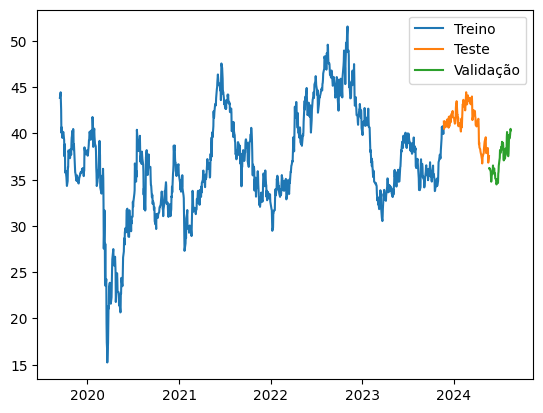

In [11]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## LSTM

Resultado com dados nunca vistos pelo modelo

In [12]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1296.1525 - mean_absolute_error: 35.5378 - val_loss: 1121.0718 - val_mean_absolute_error: 33.4229
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 611.4303 - mean_absolute_error: 23.1303 - val_loss: 7.3092 - val_mean_absolute_error: 2.4274
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.5581 - mean_absolute_error: 5.5834 - val_loss: 29.9362 - val_mean_absolute_error: 5.0989
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.2334 - mean_absolute_error: 4.3831 - val_loss: 22.9867 - val_mean_absolute_error: 4.4399
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.8382 - mean_absolute_error: 3.4369 - val_loss: 3.1278 - val_mean_absolute_error: 1.5464
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4681 - mean_absolute_error: 1.6047 - val_loss: 0.8991 - val_mean_absolute_error: 0.7432
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7574 - mean_absolute_error: 

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


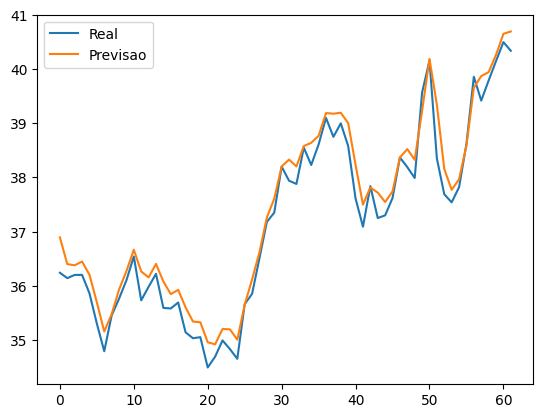

In [13]:
y_pred = model_lstm.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## FeedForward

In [14]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 708.4442 - mean_absolute_error: 23.4914 - val_loss: 31.1717 - val_mean_absolute_error: 5.5313
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.9408 - mean_absolute_error: 3.0080 - val_loss: 0.5695 - val_mean_absolute_error: 0.5852
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7918 - mean_absolute_error: 1.0160 - val_loss: 0.5483 - val_mean_absolute_error: 0.5707
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5003 - mean_absolute_error: 0.9229 - val_loss: 0.5478 - val_mean_absolute_error: 0.5709
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7485 - mean_absolute_error: 0.9628 - val_loss: 0.5506 - val_mean_absolute_error: 0.5737
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8624 - mean_absolute_error: 0.9760 - val_loss: 0.5686 - val_mean_absolute_error: 0.5848
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5109 - mean_absolute_error: 0.8983 - val_loss: 0.534

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


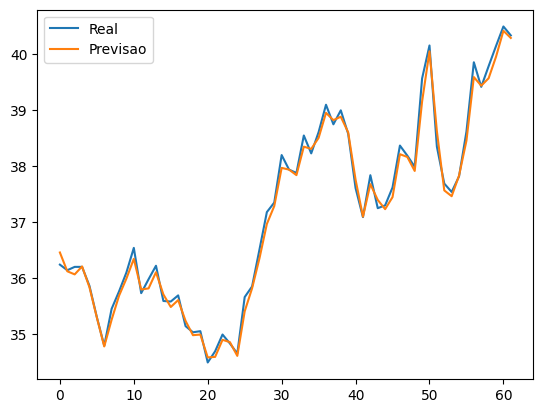

In [15]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## RNN

In [16]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1216.7074 - mean_absolute_error: 34.3584 - val_loss: 1222.0161 - val_mean_absolute_error: 34.9040
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 942.4870 - mean_absolute_error: 30.1972 - val_loss: 1090.7478 - val_mean_absolute_error: 32.9700
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 824.7639 - mean_absolute_error: 28.1881 - val_loss: 990.6987 - val_mean_absolute_error: 31.4162
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 756.9461 - mean_absolute_error: 27.0034 - val_loss: 902.4384 - val_mean_absolute_error: 29.9786
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 686.2681 - mean_absolute_error: 25.5675 - val_loss: 824.4637 - val_mean_absolute_error: 28.6486
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 599.3003 - mean_absolute_error: 23.8792 - val_loss: 753.1142 - val_mean_absolute_error: 27.3750
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 552.770

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


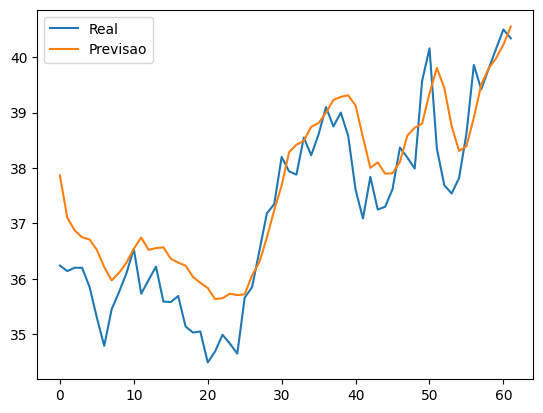

In [17]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## CNN

In [18]:
model_cnn = train_model_cnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_cnn)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 873.5639 - mean_absolute_error: 27.0518 - val_loss: 17.7709 - val_mean_absolute_error: 4.1336
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.5875 - mean_absolute_error: 3.3024 - val_loss: 0.9230 - val_mean_absolute_error: 0.7758
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3366 - mean_absolute_error: 1.1345 - val_loss: 0.6890 - val_mean_absolute_error: 0.6486
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1322 - mean_absolute_error: 1.0646 - val_loss: 0.6481 - val_mean_absolute_error: 0.6179
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9275 - mean_absolute_error: 1.0447 - val_loss: 0.6833 - val_mean_absolute_error: 0.6451
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1345 - mean_absolute_error: 1.0718 - val_loss: 0.6569 - val_mean_absolute_error: 0.6286
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9469 - mean_absolute_error: 1.0361 - val_loss: 0.650

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


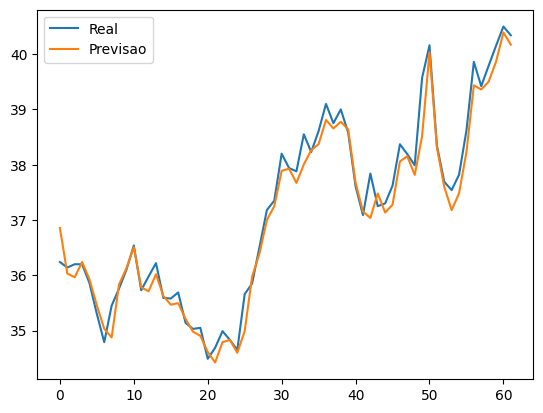

In [19]:
y_pred = model_cnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred).shift(-1), label="Previsao")
plt.legend()

## Previsão a longo prazo

In [20]:
df_teste = df.copy()

dias_uteis = dias_uteis_entre_datas('2024-08-16', '2024-09-16')

for dia in dias_uteis:
    proxima_predicao = float(predict_next_day(df_teste, model_feedforward)[-1])
    df_teste.iloc[-1, df.columns.get_loc('tomorrow')] = proxima_predicao
    df_teste = adiciona_nova_linha(df_teste, proxima_predicao, dia)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


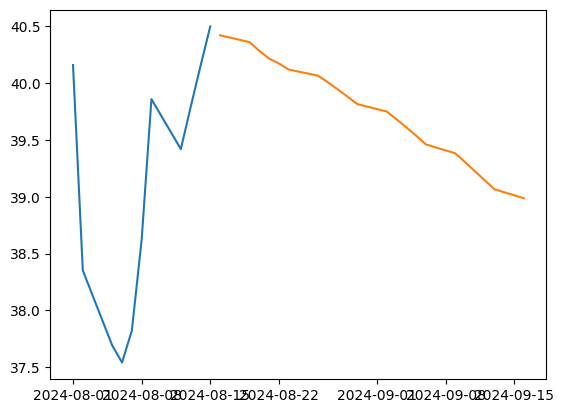

In [21]:
plt.plot(df_teste[-(len(dias_uteis)+(int(len(dias_uteis)/2))):-len(dias_uteis)]['Close'])
plt.plot(df_teste[-len(dias_uteis):]['Close'])

In [22]:
df_teste

,Close,prev-day-1,prev-day-2,prev-day-3,mm_5,mm_21,tomorrow
2019-09-13,43.433495,44.802975,45.702633,44.573063,NaN,NaN,43.863331
2019-09-16,43.863331,43.433495,44.802975,45.702633,NaN,NaN,44.453106
2019-09-17,44.453106,43.863331,43.433495,44.802975,NaN,NaN,43.583439
2019-09-18,43.583439,44.453106,43.863331,43.433495,NaN,NaN,42.533836
2019-09-19,42.533836,43.583439,44.453106,43.863331,43.573441,NaN,40.074772
...,...,...,...,...,...,...,...
2024-09-10,39.304016,39.382568,39.461021,39.537891,39.459496,39.927289,39.224640
2024-09-11,39.224640,39.304016,39.382568,39.461021,39.382027,39.900367,39.145119
2024-09-12,39.145119,39.224640,39.304016,39.382568,39.303473,39.852516,39.065758
2024-09-13,39.065758,39.145119,39.224640,39.304016,39.224420,39.784219,38.986958
